### For this project, a series of chapters from eleven different novels will be used. A combination of clustering, unsupervised feature generation, and classification models will be used to classify the texts by author.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import gutenberg, stopwords
from collections import Counter
from sklearn.linear_model import LogisticRegression

In [2]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


### The eleven novels listed below will be used for this project.

In [3]:
# Load the text files
emma = gutenberg.raw('austen-emma.txt')
persuasion = gutenberg.raw('austen-persuasion.txt')
sense = gutenberg.raw('austen-sense.txt')
busterbrown = gutenberg.raw('burgess-busterbrown.txt')
alice = gutenberg.raw('carroll-alice.txt')
ball = gutenberg.raw('chesterton-ball.txt')
brown = gutenberg.raw('chesterton-brown.txt')
thursday = gutenberg.raw('chesterton-thursday.txt')
parents = gutenberg.raw('edgeworth-parents.txt')
moby_dick = gutenberg.raw('melville-moby_dick.txt')
paradise = gutenberg.raw('milton-paradise.txt')

### Cleaning the texts and taking one chapter.

In [4]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

emma = text_cleaner(emma)
persuasion = text_cleaner(persuasion)
sense = text_cleaner(sense)
busterbrown = text_cleaner(busterbrown)
alice = text_cleaner(alice)
ball = text_cleaner(ball)
brown = text_cleaner(brown)
thursday = text_cleaner(thursday)
parents = text_cleaner(parents)
moby_dick = text_cleaner(moby_dick)
paradise = text_cleaner(paradise)

emma = emma.split('CHAPTER')
persuasion = persuasion.split('Chapter')
sense = sense.split('CHAPTER')
busterbrown = busterbrown.split('II')
alice = alice.split('CHAPTER')
ball = ball.split('II')
brown = brown.split('CHAPTER')
thursday = thursday.split('CHAPTER')
parents = parents.split('CHAPTER')
moby_dick = moby_dick.split('CHAPTER')
paradise = paradise.split('Book')

emma = emma[1]
persuasion = persuasion[1]
sense = sense[1]
busterbrown = busterbrown[1]
alice = alice[1]
ball = ball[1]
brown = ball[1]
thursday = thursday[1]
parents = parents[1]
moby_dick = moby_dick[1]
paradise = paradise[1]

In [5]:
# Checking to make sure the texts look correct:
#print(emma)
#print(persuasion)
#print(sense)
#print(bible[:1000])
#print(poems)
#print(stories)
#print(busterbrown)
#print(alice)
#print(ball)
#print(brown)
#print(thursday)
#print(parents)
#print(moby_dick)
#print(paradise)
#print(caesar)
#print(hamlet)
#print(macbeth)
#print(leaves)
# The cleaner was successful for each of the texts.

In [6]:
# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en')
emma_doc = nlp(emma)
persuasion_doc = nlp(persuasion)
sense_doc = nlp(sense)
busterbrown_doc = nlp(busterbrown)
alice_doc = nlp(alice)
ball_doc = nlp(ball)
brown_doc = nlp(brown)
thursday_doc = nlp(thursday)
parents_doc = nlp(parents)
moby_dick_doc = nlp(moby_dick)
paradise_doc = nlp(paradise)

In [7]:
# Group into sentences.
emma_sents = [[sent, "Austen"] for sent in emma_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]
sense_sents = [[sent, "Austen"] for sent in sense_doc.sents]
busterbrown_sents = [[sent, "Burgess"] for sent in busterbrown_doc.sents]
alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]
ball_sents = [[sent, "Chesterton"] for sent in ball_doc.sents]
brown_sents = [[sent, "Chesterton"] for sent in brown_doc.sents]
thursday_sents = [[sent, "Chesterton"] for sent in thursday_doc.sents]
parents_sents = [[sent, "Edgeworth"] for sent in parents_doc.sents]
moby_dick_sents = [[sent, "Melville"] for sent in moby_dick_doc.sents]
paradise_sents = [[sent, "Milton"] for sent in paradise_doc.sents]

# Combine the sentences into one data frame.
sentences = pd.DataFrame(emma_sents + persuasion_sents + sense_sents +
                         busterbrown_sents + alice_sents + ball_sents + 
                         brown_sents + thursday_sents + parents_sents + 
                         moby_dick_sents + paradise_sents)
sentences.head()

,0,1
0,"( , I, Emma, Woodhouse, ,, handsome, ,, clever...",Austen
1,"(She, was, the, youngest, of, the, two, daught...",Austen
2,"(Her, mother, had, died, too, long, ago, for, ...",Austen
3,"(Sixteen, years, had, Miss, Taylor, been, in, ...",Austen
4,"(Between, _, them, _, it, was, more, the, inti...",Austen


### The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

In [8]:
################################################################################
########## NEED TO DO BOW BEFORE CLUSTERING ####################################
################################################################################

# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
emmawords = bag_of_words(emma_doc)
persuasionwords = bag_of_words(persuasion_doc)
sensewords = bag_of_words(sense_doc)
busterbrownwords = bag_of_words(busterbrown_doc)
alicewords = bag_of_words(alice_doc)
ballwords = bag_of_words(ball_doc)
brownwords = bag_of_words(brown_doc)
thursdaywords = bag_of_words(thursday_doc)
parentswords = bag_of_words(parents_doc)
moby_dickwords = bag_of_words(moby_dick_doc)
paradisewords = bag_of_words(paradise_doc)

# Combine bags to create a set of unique words.
common_words = set(emmawords + persuasionwords + sensewords + busterbrownwords
                   + alicewords + ballwords + brownwords + thursdaywords + 
                   parentswords + moby_dickwords + paradisewords)

In [9]:
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000


,belief,humor,cope,frozen,generosity,rebellious,valdarno,respectability,eh,ash,...,lonely,disengage,say,wander,loud,chief,readily,tarsus,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"( , I, Emma, Woodhouse, ,, handsome, ,, clever...",Austen
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(She, was, the, youngest, of, the, two, daught...",Austen
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Her, mother, had, died, too, long, ago, for, ...",Austen
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Sixteen, years, had, Miss, Taylor, been, in, ...",Austen
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Between, _, them, _, it, was, more, the, inti...",Austen


In [10]:
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

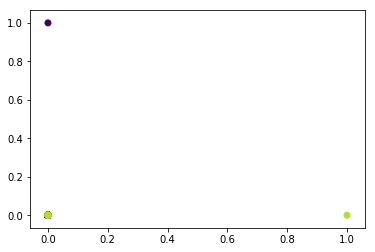

Comparing k-means clusters against the data:
text_source  Austen  Burgess  Carroll  Chesterton  Edgeworth  Melville  Milton
row_0                                                                         
0                38        3        1          18         58         1       4
1                12        0        3           1          8         0       0
2                 1        0        0           0          0         0       0
3                10        3       10          58         91         0       1
4                 0        0        0           0          0         0       1
5                 2        2        3          15         14         0       0
6                 0        0        0           0          0         0       1
7                 0        0        0           0          0         0       1
8               221       34       52         355        311         6      61
9                 0        0        0           0          0         0       1


In [11]:
# Using k-means to cluster together authors
from sklearn.cluster import KMeans

# Calculate predicted values.
y_pred = KMeans(n_clusters=10, random_state=42).fit_predict(X)

# Plot the solution.
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, Y))

Done
Estimated number of clusters: 242


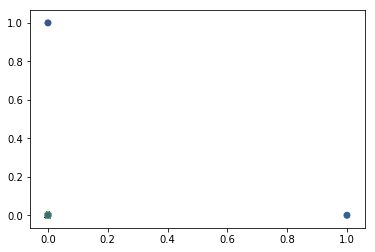

Comparing the assigned categories to the ones in the data:
col_0        0    1    2    3    4    5    6    7    8    9   ...   232  233  \
text_source                                                   ...              
Austen         1    1    1   13    1    1    1    1    1    1 ...     0    0   
Burgess        0    0    0    0    0    0    0    0    0    0 ...     0    0   
Carroll        0    0    0    0    0    0    0    0    0    0 ...     0    0   
Chesterton     0    0    0    0    0    0    0    0    0    0 ...     0    0   
Edgeworth      0    0    0    1    0    0    0    0    0    0 ...     0    0   
Melville       0    0    0    0    0    0    0    0    0    0 ...     0    0   
Milton         0    0    0    0    0    0    0    0    0    0 ...     1    1   

col_0        234  235  236  237  238  239  240  241  
text_source                                          
Austen         0    0    0    0    0    0    0    0  
Burgess        0    0    0    0    0    0    0    0  
Carr

In [12]:
## Using AffinityPropogation for clustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
 
# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(X)
print('Done')
 
# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_
 
print('Estimated number of clusters: {}'.format(n_clusters_))

plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(Y,labels))

In [13]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 11


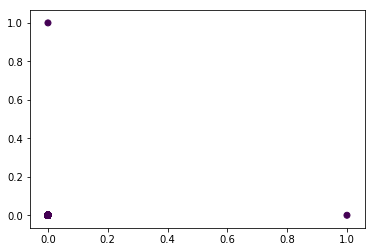

Comparing the assigned categories to the ones in the data:
col_0         0   1   2   3   4   5   6   7   8   9   10
text_source                                             
Austen       283   1   0   0   0   0   0   0   0   0   0
Burgess       42   0   0   0   0   0   0   0   0   0   0
Carroll       69   0   0   0   0   0   0   0   0   0   0
Chesterton   440   1   1   1   1   1   1   1   0   0   0
Edgeworth    478   0   0   0   0   0   0   0   1   1   2
Melville       7   0   0   0   0   0   0   0   0   0   0
Milton        70   0   0   0   0   0   0   0   0   0   0


In [14]:
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(Y,labels))

### The selected clustering technique will be K-Means due to its greater distribution of authors across the clusters in comparison to Mean Shift.

### Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. 

In [15]:
sentences_list=[]
for index, row in sentences.iterrows():
    sen = str(row[0])
    sentences_list.append(sen)

print(sentences_list[0:4])

[' I Emma Woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to unite some of the best blessings of existence; and had lived nearly twenty-one years in the world with very little to distress or vex her.', "She was the youngest of the two daughters of a most affectionate, indulgent father; and had, in consequence of her sister's marriage, been mistress of his house from a very early period.", 'Her mother had died too long ago for her to have more than an indistinct remembrance of her caresses; and her place had been supplied by an excellent woman as governess, who had fallen little short of a mother in affection.', "Sixteen years had Miss Taylor been in Mr. Woodhouse's family, less as a governess than a friend, very fond of both daughters, but particularly of Emma."]


In [16]:
# Using tf-idf

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
sentences_tfidf=vectorizer.fit_transform(sentences_list)
print("Number of features: %d" % sentences_tfidf.get_shape()[1])

Number of features: 1862


### Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

In [17]:
################################################################################
################ RESERVE 25% OF YOUR CORPUS AS A TEST SET ######################
################################################################################

from sklearn.model_selection import train_test_split

Y = sentences[1]
X = sentences[0]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=0)

In [18]:
#splitting into training and test sets using the sentences_tfidf data
X_train_tfidf, X_test_tfidf= train_test_split(sentences_tfidf, test_size=0.25, random_state=0)

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
print(n)
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[10])
print('Tf_idf vector:', tfidf_bypara[10])

1050
Original sentence: It was Miss Taylor's loss which first brought grief.
Tf_idf vector: {'laid': 0.46150794291526914, 'arthur': 0.32160003759001582, 'open': 0.3934459360056064, 'sir': 0.26990292600679988, 'sure': 0.34381918717179061, 'character': 0.41487197447351803, 'real': 0.40694735746878985}


In [19]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 40.7330402192
Component 0:
0
(", How, 's, this, ,, Susan, ?, ", said, he, .)                                                                                                                                                                                              0.687571
(The, socialists, said, he, was, cursing, priests, when, he, should, be, cursing, capitalists, .)                                                                                                                                            0.663616
(she, said, aloud, ., ')                                                                                                                                                                                                                     0.633790
(", Now, I, have, him, ,, ", said, the, cunning, tempter, to, himself, ., ")                                                                                                                

Name: 3, dtype: float64
Component 4:
0
(And, what, did, you, say, ?)                                                                                                                                         0.491774
(She, COULD, NOT, SAY, AMEN, .)                                                                                                                                       0.444781
(Give, me, Bradshaw, ,, I, say, !, ")                                                                                                                                 0.407658
(When, you, say, ', thank, you, ', for, the, salt, ,, do, you, mean, what, you, say, ?)                                                                               0.402717
(", Stay, ,, oh, stay, !, ", cried, Susan, ,, catching, the, skirt, of, his, coat, with, an, eager, ,, trembling, hand, ;, ", a, whole, week, ,, did, you, say, ?)    0.383611
(You, say, you, are, a, poet, of, law, ;, I, say, you, are, a, contradiction, in, term

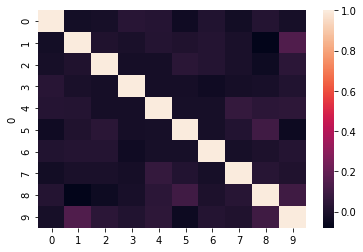

Key:
0 You dirty lunatic, stand up, will you?
1 He had returned to a late dinner, after some days' absence, and now walked up to Hartfield to say that all were well in Brunswick Square.
2 "There's our purse," said they; "do what you please with it.
3 Even if the people were not "artists," the whole was nevertheless artistic.
4 It was Miss Taylor's loss which first brought grief.
5 Sir Arthur wished to enlarge his domain, and to make a ride round it.
6 Are not sheep killed every day, and don't you eat mutton?
7 Mrs. Price was an intelligent, active, domestic woman; but her health was not robust.
8 And as not unfrequently happens to middle-aged gentlemen when they see a new youth opening before them, he found himself in the presence of the police.
9 So thick bestrown, Abject and lost, lay these, covering the flood, Under amazement of their hideous change.


In [20]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

In [21]:
lr = LogisticRegression()
train = lr.fit(X_train_lsa, y_train)
print(X_train_lsa.shape, y_train.shape)
print('Training set score:', lr.score(X_train_lsa, y_train))

(1050, 130) (1050,)
Training set score: 0.827619047619


### The visual above shows that the tfidf vectorization technique did a satisfactory job of creating unique features.

### Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

In [22]:
#Reshapes the vectorizer output into something people can read
X_test_tfidf_csr = X_test_tfidf.tocsr()

#number of paragraphs
n = X_test_tfidf_csr.shape[0]
print(n)
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_test_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_test_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_test[4])
print('Tf_idf vector:', tfidf_bypara[4])

351
Original sentence: Between _them_ it was more the intimacy of sisters.
Tf_idf vector: {'satisfy': 0.43907496133756208, 'send': 0.42140135859773781, 'lease': 0.33251062208716348, 'stir': 0.43907496133756208, 'business': 0.32567753140247291, 'sir': 0.24644745871611551, 'good': 0.2501162797206628, 'home': 0.31132552107830808}


In [23]:
#Our SVD data reducer.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the test data, then project the test data.
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 60.3348105032
Component 0:
0
(", Everything, shall, be, ready, ,, dear, mother, ;, only, do, n't, hurry, yourself, ,, ", said, Susan, .)                                                                                                                                                                                                                      0.545845
(And, if, YOU, could, help, it, ,, Susan, ?, ", said, he, .)                                                                                                                                                                                                                                                                     0.529042
(", I, shall, not, forget, it, ,, ", said, Susan, ,, steadily, .)                                                                                                                                                                                                         

Name: 2, dtype: float64
Component 3:
0
(Evan, lived, like, a, man, walking, on, a, borderland, ,, the, borderland, between, this, world, and, another, .)                                                    0.500214
(", That, we, shall, ruin, this, poor, man, ., ")                                                                                                                     0.450507
(Well, ,, well, ., ", Evan, went, out, of, the, Court, of, Justice, free, ,, but, strangely, shaken, ,, like, a, sick, man, .)                                        0.398707
(This, man, only, gave, expression, to, his, sincere, belief, ., ")                                                                                                   0.383477
(", As, how, ,, man, !, Why, ,, you, said, something, about, its, not, belonging, to, me, ,, when, you, heard, me, talk, of, inclosing, it, the, other, day, ., ")    0.372583
(For, Heaven, 's, sake, ,, man, ,, ", he, said, ,, ", do, n't, talk, so, much, .)     

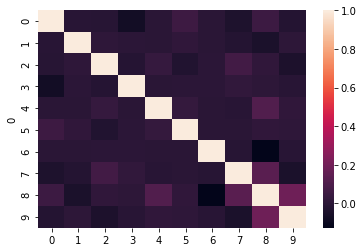

Key:
0 Gradually as this poor woman collected her scattered thoughts, she recalled the circumstances of the preceding evening.
1 And that is just what Buster Bear was doing, and it was very plain to see that he was having great fun.
2 Does it occur to you that there is any one article in which we can retrench?" and Elizabeth, to do her justice, had, in the first ardour of female alarm, set seriously to think what could be done, and had finally proposed these two branches of economy, to cut off some unnecessary charities, and to refrain from new furnishing the drawing-room; to which expedients she afterwards added the happy thought of their taking no present down to Anne, as had been the usual yearly custom.
3 And if YOU could help it, Susan?" said he.
4 When you go home, you will be so good, sir, as to send me his lease, that I may satisfy myself before we stir in this business."
5 Year after year went by, and year after year the death of God in a shop in Ludgate became a less and less

In [24]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_test_lsa) * np.asmatrix(X_test_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_test).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

### The above visual shows that the tfidf vectorization performed well in creating unique features for the ten sample sentences, with the exception of sentences three and eight having a higher correlation of .4.

In [25]:
train = lr.fit(X_train_lsa, y_train)
print(X_test_lsa.shape, y_test.shape)
print('Test set score:', lr.score(X_test_lsa, y_test))

(351, 130) (351,)
Test set score: 0.441595441595


# Initial Results:

### The project used a combination of supervised and unsupervised techniques to classify sentences by author. The Latent Semantic Analysis method captured 40.766% of the variance on the training set and 60.347% of the variance on the test set. This improvement ensures that the model is not subject to overfitting to the training set and that more exploratory analysis could yield a further improvement to results.

### The low score for the logistic regression model on the test set can be attributed to the low percent of variance captured in the training set. Improving the lsa model to capture more variance may lead to an increase in test score.

### Other options include running logistic regression on the tfidf vectors rather than the lsa vectors as well as increasing the amount of features generated by lsa.

# Improving the Model

In [42]:
# Modifying the SVD number of components
# The number of components must be less than the number of features.
# The tfidf vectorizer created approx. 1800 features, so we will use 1000.
svd= TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 99.9864052653


In [32]:
lr = LogisticRegression()
train = lr.fit(X_train_lsa, y_train)
print(X_train_lsa.shape, y_train.shape)
print('Training set score:', lr.score(X_train_lsa, y_train))

(1050, 1000) (1050,)
Training set score: 0.877142857143


In [43]:
# Trying to improve the test set.
svd= TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the test data, then project the test data.
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 100.0


In [44]:
#train = lr.fit(X_train_lsa, y_train)
print(X_test_lsa.shape, y_test.shape)
print('Test set score:', lr.score(X_test_lsa, y_test))

(351, 351) (351,)


ValueError: X has 351 features per sample; expecting 1000